## 3.6 A regression : Prediction house prices
last modified : 2021-3-22 by Imryoung Jeong

In [1]:
from IPython.display import Image

import keras
import numpy as np

In [5]:
np.set_printoptions(formatter = {'float_kind': lambda x:"{0:0.5f}".format(x)})

#### 3.6.1 The Boston housing price dataset

In [9]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [12]:
train_data[0]

array([1.23247, 0.00000, 8.14000, 0.00000, 0.53800, 6.14200, 91.70000,
       3.97690, 4.00000, 307.00000, 21.00000, 396.90000, 18.72000])

#### 3.6.2 Preparing the data : Feature-wise normalization

In [13]:
# Feature-wise normalization
# !!! Never use quantity computed on the test data !!! 

mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std


#### 3.6.3 Building your network

In [14]:
from keras import models
from keras import layers

In [21]:
def build_model():
    
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation = 'relu',
                          input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1)) 
    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    
    return model

> <ol>
    <li>The network ends with a single unit and no activation : a typical setup for scalar regression</li>
    <li><code>mse</code> loss function : the square of the difference between the predictions and the targets</li>
    <li>MAE(mean absolute error) as a new metric : the absolute value of the difference between the predictions and the targets</li>
    </ol>

#### 3.6.4. Validating your approach using K-fold validation

> If you have few data points, the validation set would end up being very small. As a consequence, the validation scores might change a lot depending on which data points you chose to use for validation; in this case, use <b>K-fold cross-validation</b> (pp.87)

In [17]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [23]:
for i in range(k) :
    
    print("processing fold #", i)
    
    # define validation data : data from partition #k
    val_data = train_data[i * num_val_samples: (i +1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i +1) * num_val_samples]
    
    # define training data : data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
        train_data[(i +1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
        train_targets[(i +1) * num_val_samples:]],
        axis = 0)
    
    # call already defined Keras model
    model = build_model()
    
    # in silent mode : vervose = 0
    model.fit(partial_train_data, partial_train_targets, 
             epochs = num_epochs, batch_size = 1, verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    
    all_scores.append(val_mae)
    
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [24]:
print(all_scores)

[2.151582956314087, 2.3438684940338135, 2.7626290321350098, 2.2059574127197266]


In [25]:
np.mean(all_scores)

2.366009473800659

In [31]:
# Saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []

for i in range(k) :
    
    print("processing fold #", i)
    
    # define validation data : data from partition #k
    val_data = train_data[i * num_val_samples: (i +1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i +1) * num_val_samples]
    
    # define training data : data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
        train_data[(i +1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
        train_targets[(i +1) * num_val_samples:]],
        axis = 0)
    
    # call already defined Keras model
    model = build_model()
    
    # in silent mode : vervose = 0
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs, batch_size = 1, verbose = 0)
    
    mae_history = history.history['val_mae']
    
    all_mae_histories.append(mae_history)

    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [30]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [32]:
# Compute the average of the per-epoch MAE scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [35]:
average_mae_history[:5]

[4.814562737941742,
 3.41514253616333,
 3.1250426173210144,
 2.8711838722229004,
 2.751814842224121]

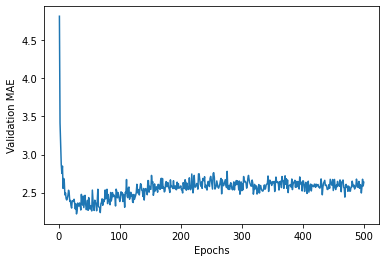

In [33]:
# Plot validation scores
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) +1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

Comments :<br>
1. Omit the first 10 data pts(to control outliers?)<br>
2. Replace each pt with an exponential moving average of the previous pts(to obtain a smooth curve)

In [38]:
def smooth_curve(points, factor = 0.9) :
    
    smoothed_points = []
    
    # Exponential moving average
    for point in points :
        if smoothed_points :
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else :
            smoothed_points.append(point)
    
    return smoothed_points

In [37]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

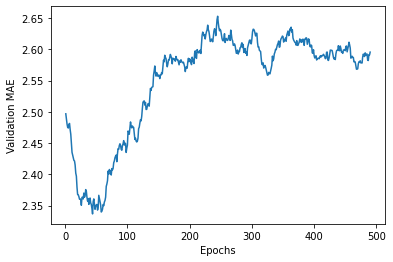

In [39]:
plt.plot(range(1, len(smooth_mae_history) +1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

> Validation MAE stops improving after 80 epochs -- past that point, you start overfitting

In [41]:
# Training the final model with adjusted epochs : 80

model = build_model()
model.fit(train_data, train_targets,
         epochs = 80, batch_size = 16, verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 17.6492 - mae: 2.6938


In [42]:
test_mae_score

2.6937756538391113

### Wrapping up
---
<ul>
    <li>MSE(Mean Squared Error) is a loss function commonly used for regression with MAE(Mean Absolute Error) as a regression metric</li>
    <li>When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step</li>
    <li>When there is little data available, using <b>K-fold Validation</b></li>
    </ul>